In [1]:
# -*- coding: utf-8 -*-

# Distributed word representations

This codelab is about methods for creating effective distributed semantic word representations. Here, "distributed" just means that the representations are vectors of real numbers, and these models are also often called __vector space models__ (VSMs). My focus is largely on methods derived from co-occurrence patterns in text, but the section [Supervised signals](#Supervised-signals) illustrates a simple method for imbuing distributional word vectors with label information.

A usage note: the term __distributional representatation__ is sometimes reserved for those derived purely from count data, and __distributed representation__ is sometimes reserved for those that involve some kind of supervised optimization.  Here, I use  __distributed representation__ in its most general form. As we will see, many models blur the supervised/distributional distinction.

## Code and data requirements

Download or clone [this Github repository](https://github.com/cgpotts/cs224u) so that you have all the files it includes. 

Download [the data distribution for this unit](https://web.stanford.edu/class/cs224u/data/distributedwordreps-data.zip), unpack it, and place it in the directory containing the above Github directory.

In addition, make sure you have the following installed:

* [Numpy, Scipy, and matplotlib](http://www.scipy.org/install.html). (Mac users: I suggest [the Scipy Superpack](http://stronginference.com/ScipySuperpack/))
* [scikit.learn](http://scikit-learn.org/)

If you want to work in and modify this notebook, you should also install [the latest iPython](http://ipython.org).

## Contents

0. [Distributional matrices](#Distributional-matrices)
0. [Vector comparison](#Vector comparison)
    0. [Euclidean distance](#Euclidean-distance)
    0. [Length normalization](#Length-normalization)
    0. [Cosine distance](#Cosine-distance)
    0. [Matching-based methods](#Matching-based-methods)
    0. [Summary](#Summary)
0. [Distributional neighbors](#Distributional-neighbors)    
0. [Matrix reweighting](#Matrix-reweighting)
    0. [Normalization](#Normalization)
    0. [Pointwise Mutual Information](#Pointwise-Mutual-Information)
    0. [TF-IDF](#TF-IDF)
0. [Dimensionality reduction](#Dimensionality-reduction)
0. [Visualization](#Visualization)
0. [The semantic orientation method](#The-semantic-orientation-method)
0. [Word-sense ambiguities](#Word-sense-ambiguities)
0. [GloVe word representations](#GloVe-word-representations)
0. [Supervised signals](#Supervised-signals)
    0. [Shallow neural network model](#Shallow-neural-network-model)
    0. [Logical operator example](#Logical-operator-example)
    0. [Sentiment lexicon example](#Sentiment-lexicon-example)
    0. [ Word-level inference relations](#Word-level-inference-relations)
0. [Word similarity evaluation](#Word-similarity-evaluation)
0. [Word analogies evaluation](#Word-analogies-evaluation)
0. [Exercises](Exercises)
    0. [Exploratory and open-ended](#Exploratory-and-open-ended)
    0. [Straightforward](#Straightforward)
    0. [Challenging](#Challenging)

In [2]:
import os
import sys
import csv
import copy
import random
import itertools
from operator import itemgetter
from collections import defaultdict

# Make sure you've got Numpy and Scipy installed:
import numpy as np
import scipy
import scipy.spatial.distance
from numpy.linalg import svd

# For visualization:
from tsne import tsne # See http://lvdmaaten.github.io/tsne/#implementations
import matplotlib.pyplot as plt

# For clustering in the 'Word-sense ambiguities' section:
from sklearn.cluster import AffinityPropagation

In [3]:
%matplotlib inline

## Distributional matrices

Here's a basic recipe for building a word $\times$ word matrix:
    
0. Define a notion of co-occurrence context. This could be an entire document, a paragraph, a sentence, a clause, an NP — whatever domain seems likely to capture the associations you care about.
0. Scan through your corpus building a dictionary $d$ mapping word-pairs to counts. Every time a pair of words $w$ and $w'$ occur in the same context (as you defined it in 1),  increment $d[(w, w')]$ by $1$.
0. Using the count dictionary $d$ that you collected in 2, establish your full vocabulary $V$, an ordered list of words types. For large collections of documents, $|V|$ will typically be huge. You will probably want to winnow the vocabulary at this point. You might do this by filtering to a specific subset, or just imposing a minimum count threshold. You might impose a minimum count threshold even if $|V|$ is small &mdash; for words with very low counts, you simply don't have enough evidence to say anything interesting.
0. Now build a matrix $M$ of dimension $|V| \times |V|$. Both the rows and the columns of $M$ represent words. Each cell $M[i, j]$ is filled with the count $d[(w_i, w_j)]$.

For different design matrices, the procedure differs slightly. For example, if you are building a word $\times$ document matrix, then the rows of $M$ represent words and the columns of $M$ represent documents. The scan in step 2 then just keeps track of (_word_, _document_) pairs &mdash; compiling the number of times that _word_ appears in _document_. Such matrices are often used in information retrieval, because the columns are multi-set representations of documents. They are much sparser than the the word $\times$ word matrices we will work with here. (In my experience, they yield lower quality lexicons, but others have reported good results with them.)

This codebook is distributed with two pre-computed matrices of co-occurrence counts in IMDB move reviews. The `build` function allows you to read them in:

In [4]:
def build(src_filename, delimiter=',', header=True, quoting=csv.QUOTE_MINIMAL):    
    reader = csv.reader(file(src_filename), delimiter=delimiter, quoting=quoting)
    colnames = None
    if header:
        colnames = reader.next()
        colnames = colnames[1: ]
    mat = []    
    rownames = []
    for line in reader:        
        rownames.append(line[0])            
        mat.append(np.array(map(float, line[1: ])))
    return (np.array(mat), rownames, colnames)

Let's read these in now for use in later examples:

In [5]:
ww = build('distributedwordreps-data/imdb-wordword.csv')
wd = build('distributedwordreps-data/imdb-worddoc.csv')

There are some great pre-computed matrices available online too. These aren't matrices of counts, but rather more abstract values computed using methods like those under discussion here. Just for kicks, load in the GloVe vectors 
included in the data distribution:

In [6]:
glv = build('distributedwordreps-data/glove.6B.50d.txt', delimiter=' ', header=False, quoting=csv.QUOTE_NONE)

## Vector comparison

Vector comparisons form the heart of our analyses in this context. For the most part, we are interested in measuring the _distance_ between vectors. The guiding idea is that semantically related words should be close together in the vector spaces we build, and semantically unrelated words should be far apart.

The [scipy.spatial.distance](http://docs.scipy.org/doc/scipy-0.14.0/reference/spatial.distance.html) module has a lot of vector comparison methods, so you might check them out if you want to go beyond the functions defined and explored here. Read the documentation closely, though: many of those methods are defined only for binary vectors, whereas the VSMs we'll use allow all float values in principle.

### Euclidean distance

The most basic and intuitive distance measure between vectors is __euclidean distance__. The euclidean distance between two vectors $u$ and $v$ of dimension $n$ is 

$$\sqrt{\sum_{i=1}^{n} |u_{i}-v_{i}|^2}$$ 

In two-dimensions, this corresponds to the length of the most direct line between the two points. Here, we just rely on 
`scipy` to define it:

In [7]:
def euclidean(u, v):
    # Use scipy's method:
    return scipy.spatial.distance.euclidean(u, v)
    # Or define it yourself:
    # return vector_length(u - v)    

The comment above shows how to define this measure yourself. The function used there is the __length__ of a vector $u$ of dimension $n$, which is defined as 

$$\|u\| = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$ 

Here's the code:

In [8]:
def vector_length(u):
    return np.sqrt(np.dot(u, u))

Here's the tiny vector space from the screencast on vector comparisons associated
with this codelab:

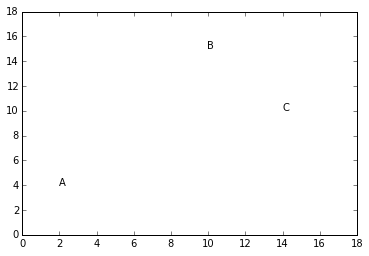

In [9]:
ABC = np.array([
    [ 2.0,  4.0],  # A
    [10.0, 15.0],  # B
    [14.0, 10.0]]) # C

def plot_ABC(m):
    plt.plot(m[:,0], m[:,1], marker='', linestyle='')
    plt.xlim([0,np.max(m)*1.2])
    plt.ylim([0,np.max(m)*1.2])
    for i, x in enumerate(['A','B','C']):
        plt.annotate(x, m[i,:])

plot_ABC(ABC)

The euclidean distances align well with the raw visual distance in the plot:

In [10]:
euclidean(ABC[0], ABC[1])

13.601470508735444

In [11]:
euclidean(ABC[1], ABC[2])

6.4031242374328485

However, suppose we think of the vectors as word meanings in the vector-space sense. In that case, the values don't look good: the distributions of B and C are more or less directly opposed, suggesting very different meanings, whereas A and B are rather closely aligned, abstracting away from the fact that the first is far  less frequent than the second. In terms of the large 
models we will soon explore, A and B resemble a pair like __superb__ and __good__, which have similar meanings but very different frequencies. In contrast, B and C are like __good__ and __disappointing__ &mdash; similar overall frequencies but different distributions with respect to the overall vocabulary.

### Length normalization

These affinities are immediately apparent if we normalize the vectors by their length. To do this, we use `vector_length`
to define `length_norm`:

In [12]:
def length_norm(u):
    return u / vector_length(u)

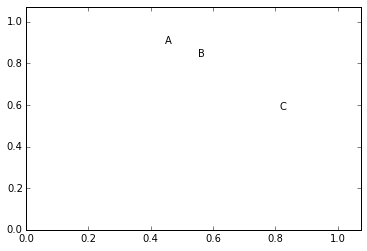

In [13]:
plot_ABC(np.array([length_norm(row) for row in ABC]))

Here, the connection between A and B is more apparent, as is the opposition between B and C.

### Cosine distance

__Cosine distance__ takes overall length into account. The cosine distance between two vectors $u$ and $v$ of dimension $n$ is 

$$1 - \left(\frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|\cdot \|v\|}\right)$$

The similarity part of this (the righthand term of the subtraction) is actually measuring the _angles_ between the two vectors. The result is the same (in terms of rank order) as one gets from first normalizing both vectors using `vector_length` and then calculating their Euclidean distance.

In [14]:
def cosine(u, v):
    # Use scipy's method:
    return scipy.spatial.distance.cosine(u, v)
    # Or define it yourself:
    # return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))

### Matching-based methods

Matching-based methods are also common in the literature. The basic `matching` measure  effectively creates a vector consisting of all of the smaller of the two values at each coordinate, and then sums them:

In [15]:
def matching(u, v):
    # The scipy implementation is for binary vectors only. This version is more general.
    return np.sum(np.minimum(u, v))

One approach to normalizing the `matching` values is the __Jaccard coefficient__. The numerator is the matching coefficient. The denominator &mdash; the normalizer &mdash; is intuitively like the set union: for binary vectors it gives the cardinality of the union of the two being compared:

In [16]:
def jaccard(u, v):
    # The scipy implementation is for binary vectors only. This version is more general.
    return 1.0 - (matching(u, v) / np.sum(np.maximum(u, v)))

### Summary

Suppose we set for ourselves the goal of associating A with B and disassociating B from C, in keeping with the semantic intuition expressed above. Then we can assess distance measures by whether they achieve this goal:

In [17]:
for m in (euclidean, cosine, matching, jaccard):
    fmt = {'name': m.__name__,  'AB': m(ABC[0], ABC[1]), 'BC': m(ABC[1], ABC[2])}
    print '%(name)15s(A, B) = %(AB)5.2f %(name)15s(B, C) = %(BC)5.2f' % fmt

      euclidean(A, B) = 13.60       euclidean(B, C) =  6.40
         cosine(A, B) =  0.01          cosine(B, C) =  0.07
       matching(A, B) =  6.00        matching(B, C) = 20.00
        jaccard(A, B) =  0.76         jaccard(B, C) =  0.31


## Distributional neighbors

The `neighbors` function is an investigative aide. For a given `word`, it ranks all the words in the vocabulary `rownames` according to their distance from `word`, as measured by `distfunc` in matrix `mat`:

In [18]:
def neighbors(word=None, mat=None, rownames=None, distfunc=cosine):
    if word not in rownames:
        raise ValueError('%s is not in this VSM' % word)
    w = mat[rownames.index(word)]
    dists = [(rownames[i], distfunc(w, mat[i])) for i in xrange(len(mat))]
    return sorted(dists, key=itemgetter(1), reverse=False)

By playing around with this function, you can start to get a sense for how the distance functions differ. Here are some example calls; you might try some new words to get a feel for what these matrices are like and how different words look.

In [19]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=cosine)[: 5]

[('superb', 0.0),
 ('excellent', 0.0026965023912962627),
 ('outstanding', 0.0027344413235226295),
 ('beautifully', 0.0027345163104325332),
 ('brilliant', 0.0027888643627086429)]

In [20]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=euclidean)[: 5]

[('superb', 0.0),
 ('familiar', 1448.8919904533948),
 ('violent', 1630.3723501090174),
 ('follows', 1647.0276257549538),
 ('convincing', 1701.2260284865147)]

The above rankings actually tend to look pretty good, with `cosine` less likely to associate words that happen to have similar frequency. 

The GloVe vectors look even better &mdash; but they are based on much more than just raw counts, as we'll see soon:

In [21]:
neighbors(word='superb', mat=glv[0], rownames=glv[1], distfunc=cosine)[: 5]

[('superb', 2.2204460492503131e-16),
 ('brilliant', 0.15809110259014747),
 ('impressive', 0.19352861376442654),
 ('masterful', 0.22871323564771928),
 ('excellent', 0.22928471014596696)]

## Matrix reweighting

The goal of reweighting is to amplify the important, trustworthy, and unusual, while deemphasizing the mundane and the quirky. Absent a defined objective function, this will remain fuzzy, but the intuition behind moving away from raw counts is that 
frequency is a poor proxy for our target semantic ideas.

### Normalization

Normalization (row-wise or column-wise) is perhaps the simplest form of reweighting. With [length_norm](#Length-normalization), we normalize using `vector_length`. We can also normalize each row by the sum of its values, which turns each row into a probability distribution over the columns:

In [22]:
def prob_norm(u):
    return u / np.sum(u)

These normalization measures are insensitive to the _magnitude_ of the underlying counts. This is often a mistake in the messy world of large data sets; $[1,10]$ and $[1000,10000]$ are very different in ways that will be partly or totally obscured by normalization.

### Pointwise Mutual Information

__Pointwise Mutual Information__ (PMI) addresses this issue, at least in part. The PMI for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)$$

with $\log(0) = 0$. This is a measure of how far that cell's value deviates from what we would expect given the row and column sums for that cell. 

__Positive PMI__ (PPMI) maps all negative PMI values to 0.0. Our function `pmi` has `positive=True` as a default,
in light of the arguments in [Levy and Goldberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization), section 3.3.

In [23]:
def pmi(mat=None, rownames=None, positive=True):
    """PMI on mat; positive=True does PPMI. rownames is not used; it's 
    an argument only for consistency with other methods used here"""
    # Joint probability table:
    p = mat / np.sum(mat, axis=None)
    # Pre-compute column sums:
    colprobs = np.sum(p, axis=0)
    # Vectorize this function so that it can be applied rowwise:
    np_pmi_log = np.vectorize((lambda x : _pmi_log(x, positive=positive)))
    p = np.array([np_pmi_log(row / (np.sum(row)*colprobs)) for row in p])   
    return (p, rownames)

def _pmi_log(x, positive=True):
    """Maps 0 and negative values to 0.0, otherwise to log. With positive=True, maps negative values to 0."""
    val = 0.0
    if x > 0.0:
        val = np.log(x)
    if positive:
        val = max([val,0.0])
    return val

Here, we reweight the word $\times$ word IMDB matrix from above using PPMI:

In [24]:
ww_ppmi = pmi(mat=ww[0], rownames=ww[1], positive=True)

In [25]:
neighbors(word='superb', mat=ww_ppmi[0], rownames=ww_ppmi[1], distfunc=cosine)[: 5]

[('superb', 0.0),
 ('excellent', 0.41348274842943578),
 ('performances', 0.4439162856870249),
 ('brilliant', 0.45785117509986151),
 ('performance', 0.46856555779383213)]

### TF-IDF

Perhaps the best known reweighting schemes is __Term Frequency&ndash;Inverse Document Frequency__ (TF-IDF), which is, I believe, still the backbone of today's Web search technologies. As the name suggests, it is built from TF and IDF measures:

For a word $w$ and collection of documents $D$ containing document $d$:

* TF$(w,d)$: $P(w \mid c)$. (In our VSMs, this is column-normalization using `prob_norm`.)
* IDF$(w,D)$: $\log\left(\frac{|D|}{|\{d \in D : w \in d\}|}\right)$, where $\log(0)=0$.
* TFIDF$(w,d,D)$: TF$(w,d)$ * IDF$(w,D)$

In [26]:
def tfidf(mat=None, rownames=None):
    """TF-IDF on mat. rownames is unused; it's an argument only 
    for consistency with other methods used here"""
    colsums = np.sum(mat, axis=0)
    doccount = mat.shape[1]
    w = np.array([_tfidf_row_func(row, colsums, doccount) for row in mat])
    return (w, rownames)

def _tfidf_row_func(row, colsums, doccount):
    df = float(len([x for x in row if x > 0]))
    idf = 0.0
    # This ensures a defined IDF value >= 0.0:
    if df > 0.0 and df != doccount:
        idf = np.log(doccount / df)
    tfs = row/colsums
    return tfs * idf

TF-IDF generally performs best with sparse matrices. It severely punishes words that appear in many documents; if a word appears in every document, then it's IDF value is 0. As a result, it can even be problematic with verb dense word $\times$ word 
matrices like `ww`, where most words appear with most other words due to the permissive notion of co-occurrence used to create it.

Here's an example using our word&nbsp;x&nbsp;document matrix `wd`:

In [27]:
wd_tfidf = tfidf(mat=wd[0], rownames=wd[1])

In [28]:
neighbors(word='superb', mat=wd_tfidf[0], rownames=wd_tfidf[1], distfunc=cosine)[: 5]

[('superb', 0.0),
 ('outstanding', 0.72256301656130351),
 ('remain', 0.73606093603489886),
 ('viewed', 0.74639986506462097),
 ('and', 0.74880553661599958)]

## Dimensionality reduction

The above methods deliver solid results. However, they are not capable of capturing higher-order associations in the data. For example, both _gnarly_ and _wicked_ are used as slangily positive adjectives. We thus expect them to have many of the same neighbors. However, at least stereotypically, _gnarly_ is Californian and _wicked_ is Bostonian. Thus, they are unlikely 
to occur often in the same texts. Dimensionality reduction techniques are often capable of capturing their semantic similarity (and have the added advantage of shrinking the size of our data structures).

The general goal of dimensionality reduction is eliminate rows/columns that are highly correlated while bringing similar things together and pushing dissimilar things apart. __Latent Semantic Analysis__ (LSA) is a prominent method. It is an application of truncated __singular value decomposition__ (SVD). SVD is a central matrix operation; 'truncation' here means looking only at submatrices of the full decomposition. LSA seeks not only to find a reduced-sized matrix but also to capture similarities that come not just from direct co-occurrence, but also from second-order co-occurrence.

In [29]:
def lsa(mat=None, rownames=None, k=100):
    """svd with a column-wise truncation to k dimensions; rownames 
    is passed through only for consistency with other methods"""
    rowmat, singvals, colmat = svd(mat, full_matrices=False)
    singvals = np.diag(singvals)
    trunc = np.dot(rowmat[:, 0:k], singvals[0:k, 0:k])
    return (trunc, rownames)

Here's a look at the example from the slides:

In [30]:
gnmat = np.array([
    [1,0,1,0,0,0],
    [0,1,0,1,0,0],
    [1,1,1,1,0,0],
    [0,0,0,0,1,1],
    [0,0,0,0,0,1]], dtype='float64')
gn_rownames = ['gnarly', 'wicked', 'awesome', 'lame', 'terrible']

In [31]:
neighbors(word='gnarly', mat=gnmat, rownames=gn_rownames)

[('gnarly', 2.2204460492503131e-16),
 ('awesome', 0.29289321881345254),
 ('wicked', 1.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

We see that _gnarly_ and _wicked_ are not close to each other. (Well, it's a small space, but they are as close as _gnarly_ and _lame_.) Reweighting by PMI, PPMI, or TF-IDF is no help. LSA to the rescue:

In [32]:
gnmat_lsa = lsa(mat=gnmat, rownames=gn_rownames, k=2)

In [33]:
neighbors(word='gnarly', mat=gnmat_lsa[0], rownames=gnmat_lsa[1])

[('gnarly', 0.0),
 ('wicked', 0.0),
 ('awesome', 0.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

## Visualization

You can begin to get a feel for what your matrix is like by poking around with the `neighbors` function to see who is close to or far from whom. But this kind of sampling is unlikely to lead to robust new insights, unless you luck out and start to see an interesting cluster of associations developing.

[t-Distributed Stochastic Neighbor Embedding](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) (t-SNE) is a powerful method for visualizing high-dimensional vector spaces in 2d. It allows you to find associations in an intuitive way, to guide later and more precise investigations. Its lead developer, [Laurens van der Maaten](http://lvdmaaten.github.io/tsne/), distributes a number of implementations of it. The following function uses his Python version, together with `matplotlib` to visualize the results.

In [34]:
def tsne_viz(
        mat=None,
        rownames=None,
        indices=None,
        colors=None,
        output_filename=None,
        figheight=40,
        figwidth=50,
        display_progress=False): 
    """2d plot of mat using tsne, with the points labeled by rownames, aligned with colors (defaults to all black).
    If indices is a list of indices into mat and rownames, then it determines a subspace of mat and rownames to display.
    Give output_filename a string argument to save the image to disk.
    figheight and figwidth set the figure dimensions.
    display_progress=True shows the information that the tsne method prints out."""
    if not colors:
        colors = ['black' for i in range(len(rownames))]
    temp = sys.stdout
    if not display_progress:
        # Redirect stdout so that tsne doesn't fill the screen with its iteration info:
        f = open(os.devnull, 'w')
        sys.stdout = f
    tsnemat = tsne(mat)
    sys.stdout = temp
    # Plot coordinates:
    if not indices:
        indices = range(len(rownames))        
    vocab = np.array(rownames)[indices]
    xvals = tsnemat[indices, 0] 
    yvals = tsnemat[indices, 1]
    # Plotting:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(40)
    fig.set_figwidth(50)
    ax.plot(xvals, yvals, marker='', linestyle='')
    # Text labels:
    for word, x, y, color in zip(vocab, xvals, yvals, colors):
        ax.annotate(word, (x, y), fontsize=8, color=color)
    # Output:
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
    else:
        plt.show()

Here's the code for running this on `ww_pmi` using the default settings:

In [35]:
# tsne_viz(mat=ww_ppmi[0], rownames=ww_ppmi[1])

It takes a while to produce this, so here's an example of the output: [fig/imdb-wordword-ppmi.pdf](fig/imdb-wordword-ppmi.pdf). (t-SNE's output will vary somewhat from run to run).

For more on the techniques, we highly recommend van der Maaten's compelling
talk [Visualizing Data Using t-SNE](https://www.youtube.com/watch?v=RJVL80Gg3lA).

## The semantic orientation method

The t-SNE visualization of our running example suggests some lexical clusters that in turn suggest the beginnings of a lexicon. The __semantic orientation__ method of [Turney and Littman 2003](http://doi.acm.org/10.1145/944012.944013) is a general method for building such lexicons for any desired semantic dimension.

The method simply exploits our above insights about vector similarity. Here are the steps:

0. Define two seed-sets $S_1$ and $S_2$ of words (they should be opposing in some way that is appropriate for your matrix).
0. Pick a vector distance measure $f$.
0. For the word $w$ of interest, use $f$ to get the sum of all distances between $w$ and the words in $S_1$. Do the same for $S_2$.
0. The score is the sum for $S_1$ minus the sum for $S_2$.

Here's an implementation; the default seed values correspond to Turney and Littman's basic sentiment experiment.

In [36]:
def semantic_orientation(
        mat=None, 
        rownames=None,
        seeds1=['bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior'],
        seeds2=['good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior'],
        distfunc=cosine):
    sm1 = so_seed_matrix(seeds1, mat, rownames)
    sm2 = so_seed_matrix(seeds2, mat, rownames)
    scores = [(rownames[i], so_row_func(mat[i], sm1, sm2, distfunc)) for i in xrange(len(mat))]
    return sorted(scores, key=itemgetter(1), reverse=False)

def so_seed_matrix(seeds, mat, rownames):
    indices = [rownames.index(word) for word in seeds if word in rownames]
    if not indices:
        raise ValueError('The matrix contains no members of the seed set: %s' % ",".join(seeds))
    return mat[np.array(indices)]
    
def so_row_func(row, sm1, sm2, distfunc):
    val1 = np.sum([distfunc(row, srow) for srow in sm1])
    val2 = np.sum([distfunc(row, srow) for srow in sm2])
    return val1 - val2    

An example function call using `ww_ppmi`:

In [37]:
so = semantic_orientation(mat=ww_ppmi[0], rownames=ww_ppmi[1])
so[:5]

[('poor', -1.2397213851709856),
 ('bad', -1.2213826663029765),
 ('worst', -1.1351666124996971),
 ('awful', -1.1048739686983322),
 ('waste', -1.0236360853957418)]

In [38]:
so[-5:]

[('well', 0.75360884916526505),
 ('superior', 0.81493927722684845),
 ('great', 0.89100807935189241),
 ('nice', 0.93295714329167501),
 ('excellent', 1.1687082653604852)]

## Word-sense ambiguities

Distributional approaches are often criticized on the grounds that they do not allow for word-sense ambiguities. This is a fair criticism of the models explored so far. A method for addressing this shortcoming was proposed by [Reisinger and Mooney (2010)](https://aclweb.org/anthology/N/N10/N10-1013.pdf) building on ideas from [Sch&uuml;tze (1998)](http://www.aclweb.org/anthology/J/J98/J98-1004.pdf). Here is a simplified version of their method:
    
0. For each word $w$ in a word $\times$ context matrix $M$, cluster the columns (contexts) containing $w$ using a clustering algorithm. 
0. For each token of $w$ in each of its contexts $d$, subscript $w$ with the cluster index of $d$ according to the clustering done in step 1.
0. Rebuild the matrix with the rows now labeled with the expanded vocabulary obtained at step 2.

The success of this method will depend a lot on the clustering algorithm used. The implementation below uses [Affinity Propagation](http://scikit-learn.org/stable/modules/clustering.html#affinity-propagation), which allows different numbers of clusters for each word, which seems desirable. [K-means](http://scikit-learn.org/stable/modules/clustering.html#k-means) actually works well too, and one could think about methods for setting $k$ for each word $w$ based on properties of the documents containing $w$.

In [39]:
def disambiguate(mat=None, rownames=None, minval=0.0):
    """Basic unsupervised disambiguation. minval sets what it means to occur in a column"""
    clustered = defaultdict(lambda : defaultdict(int))
    # For each word, cluster the documents containing it:
    for w_index, w in enumerate(rownames):
        doc_indices = np.array([j for j in range(mat.shape[1]) if mat[w_index,j] > minval])
        clust = cluster(mat, doc_indices) 
        for doc_index, c_index in clust:
            w_sense = "%s_%s" % (w, c_index)
            clustered[w_sense][doc_index] = mat[w_index, doc_index]
    # Build the new matrix:
    new_rownames = sorted(clustered.keys())
    new_mat = np.zeros((len(new_rownames), mat.shape[1]))
    for i, w in enumerate(new_rownames):
        for j in clustered[w]:            
            new_mat[i,j] = clustered[w][j]
    return (new_mat, new_rownames)

def cluster(mat, doc_indices):    
    X = mat[:, doc_indices].T
    # Other clustering algorithms can easily be swapped in: 
    # http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster
    clust = AffinityPropagation()
    clust.fit(X)    
    return zip(doc_indices,  clust.labels_)     

Here's a small idealized example meant to highlight what the algorithm does mechanically and what it is supposed to do empirically. The idea is that _crane_ is ambiguous between a piece of machinery and a bird. The words _bird_ and _fly_ bias heavily in favor of the 'bird' sense, and the words _equipment_ and _hoist_ bias heavily in favor of the 'machine' sense. 'tall' is more subtly biased in favor of the _machine_ sense.

In [40]:
cranes = np.array([
    [1, 1, 1, 1, 1, 1],  # crane 
    [1, 1, 1, 0, 0, 0],  # bird
    [0, 1, 1, 0, 0, 0],  # fly
    [0, 0, 0, 1, 1, 1],  # equipment
    [0, 0, 0, 1, 1, 0],  # hoist
    [0, 0, 1, 1, 1, 0]], # tall
    dtype='float64')

crane_vocab = ['crane', 'bird', 'fly', 'equipment', 'hoist', 'tall']

When we run `disambiguate` things work out nicely for the target _crane_. The algorithm creates a lot of spurious ambiguities, but these seem to remain close together in vector space, so we might be able to collapse them in a follow-up step. (For example if two words $w_i$ and $w_j$ are sufficiently close in the vector space and share the same orthographic form, then we collapse them back down again.)

In [41]:
crane_da = disambiguate(mat=cranes, rownames=crane_vocab)

In [42]:
neighbors(mat=crane_da[0], word='crane_0', rownames=crane_da[1])

[('crane_0', -2.2204460492503131e-16),
 ('bird_1', 0.18350341907227408),
 ('bird_0', 0.42264973081037416),
 ('fly_0', 0.42264973081037416),
 ('fly_1', 0.42264973081037416),
 ('tall_0', 0.42264973081037416),
 ('crane_1', 1.0),
 ('equipment_0', 1.0),
 ('equipment_1', 1.0),
 ('hoist_0', 1.0),
 ('hoist_1', 1.0),
 ('tall_1', 1.0),
 ('tall_2', 1.0)]

In [43]:
neighbors(mat=crane_da[0], word='crane_1', rownames=crane_da[1])

[('crane_1', -2.2204460492503131e-16),
 ('equipment_0', 0.18350341907227408),
 ('equipment_1', 0.42264973081037416),
 ('hoist_0', 0.42264973081037416),
 ('hoist_1', 0.42264973081037416),
 ('tall_1', 0.42264973081037416),
 ('tall_2', 0.42264973081037416),
 ('bird_0', 1.0),
 ('bird_1', 1.0),
 ('crane_0', 1.0),
 ('fly_0', 1.0),
 ('fly_1', 1.0),
 ('tall_0', 1.0)]

## GloVe word representations

We've so far performed our matrix manipulations without an explicit objective function. Rather, we've just had in mind informal ideas about capturing semantic relatedness. The  advantage of an explicit objective function is that we can apply standard optimization techniques.

[Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf) introduce an objective function for semantic word representations. Roughly speaking, the objective is to learn vectors for words $w_{1}$ and $w_{j}$ such that their dot product is proportional to their co-occurrence count. I won't venture a full technical summary of the GloVe method here. Check out [the GloVe project homepage](http://nlp.stanford.edu/projects/glove/), which links to C code, word vectors, and other resources. I also highly recommend
[Jeffrey Pennington's EMNLP talk 'Global vectors for word representation'](https://www.youtube.com/watch?v=RyTpzZQrHCs).

The following implementation is an attempt to give the most stripped-down, bare-bones version of the GloVe method possible. In the papers and associated implementation, the authors use the [Adaptive Gradient (AdaGrad) learning method](http://jmlr.org/papers/v12/duchi11a.html). [Jon Gauthier released a Python version that uses that method as well](http://www.foldl.me/2014/glove-python/). Both of these implementations also do considerably more sophisticated things when it comes to compiling the basic co-occurrence counts. The code here is really just meant for instructional purposes. That said, it's a testament to the power of the method that it delivers high quality word vectors even in this basic form!

In [44]:
def randmatrix(m, n, lower=-0.5, upper=0.5):
    """Creates an m x n matrix of random values in [lower, upper]"""
    return np.array([random.uniform(lower, upper) for i in range(m*n)]).reshape(m, n)

In [45]:
def glove(
        mat=None, rownames=None, 
        n=100, xmax=100, alpha=0.75, 
        iterations=100, learning_rate=0.05, 
        display_progress=False):
    """Basic GloVe. rownames is passed through unused for compatibility
    with other methods. n sets the dimensionality of the output vectors.
    xmax and alpha controls the weighting function (see the paper, eq. (9)).
    iterations and learning_rate control the SGD training.
    display_progress=True prints iterations and current error to stdout."""    
    m = mat.shape[0]
    W = randmatrix(m, n) # Word weights.
    C = randmatrix(m, n) # Context weights.
    B = randmatrix(2, m) # Word and context biases.
    indices = range(m)
    for iteration in range(iterations):
        error = 0.0        
        random.shuffle(indices)
        for i, j in itertools.product(indices, indices):
            if mat[i,j] > 0.0:     
                # Weighting function from eq. (9)
                weight = (mat[i,j] / xmax)**alpha if mat[i,j] < xmax else 1.0
                # Cost is J' based on eq. (8) in the paper:
                diff = np.dot(W[i], C[j]) + B[0,i] + B[1,j] - np.log(mat[i,j])                
                fdiff = diff * weight                
                # Gradients:
                wgrad = fdiff * C[j]
                cgrad = fdiff * W[i]
                wbgrad = fdiff
                wcgrad = fdiff
                # Updates:
                W[i] -= (learning_rate * wgrad) 
                C[j] -= (learning_rate * cgrad) 
                B[0,i] -= (learning_rate * wbgrad) 
                B[1,j] -= (learning_rate * wcgrad)                 
                # One-half squared error term:                              
                error += 0.5 * weight * (diff**2)
        if display_progress:
            print "iteration %s: error %s" % (iteration, error)
    # Return the sum of the word and context matrices, per the advice 
    # in section 4.2:
    return (W + C, rownames)

The following take a while to run, but the results look good, and they can be  improved by adding more vocabulary items, allowing more iterations, and increasing the dimension size. For the output with 100 dimensions and 100 iterations, check out this image: [fig/imdb-wordword-glove100.pdf](fig/imdb-wordword-glove100.pdf).

In [46]:
def glove_viz(mat=None, rownames=None, word_count=1000, iterations=10, n=50, display_progress=True):
    glove_indices = random.sample(range(len(rownames)), word_count)
    glovemat = glove(mat=mat[glove_indices, :], iterations=iterations, n=n)
    tsne_viz(mat=glovemat, rownames=np.array(rownames)[glove_indices])

In [47]:
# glove_viz(mat=ww[0], rownames=ww[1])

## Supervised signals

The above methods rely entirely on co-occurrence patterns to achieve word representations. From a semantic perspective, this can seem unnatural. Grounding in the world is a crucial part of natural language meaning; without some connection to the world, we're missing important aspects of meaning.

Distributed approaches are compatible with grounding, though. The goal of the current section is to illustrate this possibility with a simple example involving sentiment. The guiding idea is that the labels in a sentiment lexicon provide one very specific kind of grounding, in emotional states. This information is probably not recoverable entirely from distributional facts, but we can bring it into our distributed representations.

The method employed here for imbuing distributional vectors with sentiment information is a [shallow neural network](http://ufldl.stanford.edu/wiki/index.php/UFLDL_Tutorial). The inputs to the network are matrices as we constructed them above. I particularly recommend applying PPMI first (count vectors will be problematic), and LSA might also be a valuable preprocessing step. Using the backpropagation algorithm, we learn a weight vector that derives hidden representations from our inputs. These  hidden representations are our word representations. If all goes well, they will encode both the distributional information present in the input vectors and the label information from our lexicon.

### Shallow neural network model

Here's a very basic shallow neural network implementation with stochastic gradient descent (SGD) training. (See [the exercises](#Exercises) for suggestions on how to improve this code.)

In [48]:
from numpy import dot, outer

class ShallowNeuralNetwork:
    def __init__(self, input_dim=0, hidden_dim=0, output_dim=0, afunc=np.tanh, d_afunc=(lambda z : 1.0 - z**2)):        
        self.afunc = afunc 
        self.d_afunc = d_afunc      
        self.input = np.ones(input_dim+1)   # +1 for the bias                                         
        self.hidden = np.ones(hidden_dim+1) # +1 for the bias        
        self.output = np.ones(output_dim)        
        self.iweights = randmatrix(input_dim+1, hidden_dim)
        self.oweights = randmatrix(hidden_dim+1, output_dim)        
        self.oerr = np.zeros(output_dim+1)
        self.ierr = np.zeros(input_dim+1)
        
    def forward_propagation(self, ex):        
        self.input[ : -1] = ex # ignore the bias
        self.hidden[ : -1] = self.afunc(dot(self.input, self.iweights)) # ignore the bias
        self.output = self.afunc(dot(self.hidden, self.oweights))
        return copy.deepcopy(self.output)
        
    def backward_propagation(self, labels, alpha=0.5):
        labels = np.array(labels)       
        self.oerr = (labels-self.output) * self.d_afunc(self.output)
        herr = dot(self.oerr, self.oweights.T) * self.d_afunc(self.hidden)
        self.oweights += alpha * outer(self.hidden, self.oerr)
        self.iweights += alpha * outer(self.input, herr[:-1]) # ignore the bias
        return np.sum(0.5 * (labels-self.output)**2)

    def train(self, training_data, maxiter=5000, alpha=0.05, epsilon=1.5e-8, display_progress=False):       
        iteration = 0
        error = sys.float_info.max
        while error > epsilon and iteration < maxiter:            
            error = 0.0
            random.shuffle(training_data)
            for ex, labels in training_data:
                self.forward_propagation(ex)
                error += self.backward_propagation(labels, alpha=alpha)           
            if display_progress:
                print 'completed iteration %s; error is %s' % (iteration, error)
            iteration += 1
                    
    def predict(self, ex):
        self.forward_propagation(ex)
        return copy.deepcopy(self.output)
        
    def hidden_representation(self, ex):
        self.forward_propagation(ex)
        return self.hidden

### Logical operator example

Logical operators like 'iff' and 'xor' provides early motivation for hidden representations (see [Rumelhart et al. 1985](http://psych.stanford.edu/~jlm/papers/PDP/Volume%201/Chap8_PDP86.pdf)), so it's satisfying to show that the above code can learn such operators (at least on most runs). Here an example involving 'iff':

In [49]:
def iff_example():
    iff_train = [
        ([1.,1.], [1.]), # T T ==> T
        ([1.,0.], [0.]), # T F ==> F
        ([0.,1.], [0.]), # F T ==> F
        ([0.,0.], [1.])] # F F ==> T
    net = ShallowNeuralNetwork(input_dim=2, hidden_dim=4, output_dim=1)
    net.train(copy.deepcopy(iff_train))    
    for ex, labels in iff_train:
        prediction = net.predict(ex)
        hidden_rep = net.hidden_representation(ex)  
        print ex, labels, np.round(prediction, 2), np.round(hidden_rep, 2)

iff_example()

[1.0, 1.0] [1.0] [ 0.98] [-0.81  0.87  0.98  0.47  1.  ]
[1.0, 0.0] [0.0] [ 0.] [-0.98 -0.62  0.79  0.77  1.  ]
[0.0, 1.0] [0.0] [ 0.] [ 0.53  0.99  0.86 -0.04  1.  ]
[0.0, 0.0] [1.0] [ 0.99] [-0.56  0.71  0.15  0.43  1.  ]


### Sentiment lexicon example

To close this section, let's look a somewhat more useful and complex example involving a multidimensional sentiment lexicon. This is actually on its way to being a useful general purpose sentiment resource!

The first function just processes the sentiment lexicon included in the data distribution (`Warriner_et_al emot ratings.csv`). We keep only the overall values for the three sentiment dimensions, and we rescale them into the space [-1,1]. (Somewhat counter intuitively, for the valence dimensions, the low values are positive and the high values are negative, because of the original rating scale.)

In [50]:
def read_valence_arousal_dominance_lexicon(src_filename='distributedwordreps-data/Warriner_et_al emot ratings.csv'):
    rescaler = (lambda x : np.tanh(float(x)-5))
    lex = {}
    for d in csv.DictReader(file(src_filename)):
        vals = {'valence': rescaler(d['V.Mean.Sum']), 
                'arousal': rescaler(d['A.Mean.Sum']), 
                'dominance': rescaler(d['A.Mean.Sum'])}
        lex[d['Word']] = vals
    return lex

The next function uses a distributional matrix and a lexicon to create a training set consisting of all the items in the matrix that are also in the lexicon:

In [51]:
def build_supervised_dataset(mat=None, rownames=None, lex=None):
    data = []
    vocab = []
    for word, vals in lex.items():
        if word in rownames:
            vocab.append(word)
            data.append((mat[rownames.index(word)], [y for _, y in sorted(vals.items())]))
    return (data, vocab)

We're now ready to train the model and view the results:

In [52]:
def sentiment_lexicon_example(
        mat=None, 
        rownames=None, 
        hidden_dim=100, 
        maxiter=1000, 
        output_filename=None, 
        display_progress=False):
    # Get the lexicon:
    lex = read_valence_arousal_dominance_lexicon()
    # Build the training data:
    sentidata, sentivocab = build_supervised_dataset(mat=mat, rownames=rownames, lex=lex)
    # Set up the network:
    sentinet = ShallowNeuralNetwork(input_dim=len(sentidata[0][0]), hidden_dim=hidden_dim, output_dim=len(sentidata[0][1]))
    # Train the network:
    sentinet.train(copy.deepcopy(sentidata), maxiter=maxiter, display_progress=display_progress)
    # Build the new matrix of hidden representations:
    inputs, labels = zip(*sentidata)
    sentihidden = np.array([sentinet.hidden_representation(x) for x in inputs])
    # Visualize the results with t-SNE:
    def colormap(vals):
        """Simple way to distinguish the 2x2x2 possible labels -- could be done much better!"""
        signs = ['CC' if x < 0.0 else '00' for _, x in sorted(vals.items())]
        return "#" + "".join(signs)    
    colors = [colormap(lex[word]) for word in sentivocab]
    tsne_viz(mat=sentihidden, rownames=sentivocab, colors=colors, display_progress=display_progress, output_filename=output_filename)

The function `sentiment_lexicon_example` takes a while to run with reasonable keyword arguments. To see what the results tend to look like with the default  values, here's an informal comparison of the matrix `ww`, reweighted with Positive PMI, before and after supervised sentiment training: [fig/imdb-wordword-ppmi-nn.pdf](fig/imdb-wordword-ppmi-nn.pdf).

### Word-level inference relations

[Bowman et al. (2015)](http://arxiv.org/abs/1410.4176) use neural networks to predict the relationship between words. 
The data distribution for this unit includes one of their experiment files, `longer_shuffled_synset_relations.tsv`. The left column gives the semantic relation (`hyponym`, `hypernym`, `coordinate`), and the middle and right columns give the two words. We can use `ShallowNeuralNetwork` to train models that perform this prediction task, beginning either from randomly initialized input vectors or from distributional vectors.

## Word similarity evaluation

The function `word_similarity_evaluation` lets you evaluate a matrix `mat` against the human word similarity judgments in words in the WordSim-353 dataset. If you haven't already, [download that data set](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/wordsim353.zip) and unzip it so that the directory `wordsim353` is inside the directory containing this file.

In [53]:
def word_similarity_evaluation(src_filename="distributedwordreps-data/wordsim353/combined.csv", 
        mat=None, rownames=None, distfunc=cosine):
    # Read in the data:
    reader = csv.DictReader(file(src_filename))
    sims = defaultdict(list)
    vocab = set([])
    for d in reader:
        w1 = d['Word 1']
        w2 = d['Word 2']
        if w1 in rownames and w2 in rownames:
            # Use negative of scores to align intuitively with distance functions:
            sims[w1].append((w2, -float(d['Human (mean)'])))
            sims[w2].append((w1, -float(d['Human (mean)'])))
            vocab.add(w1)
            vocab.add(w2)
    # Evaluate the matrix by creating a vector of all_scores for the wordsim353 data
    # and all_dists for mat's distances. 
    all_scores = []
    all_dists = []
    for word in vocab:
        vec = mat[rownames.index(word)]
        vals = sims[word]
        cmps, scores = zip(*vals)
        all_scores += scores
        all_dists += [distfunc(vec, mat[rownames.index(w)]) for w in cmps]
    # Return just the rank correlation coefficient (index [1] would be the p-value):
    return scipy.stats.spearmanr(all_scores, all_dists)[0]   

Evaluation is then simple. Here's the evaluation using the `ww_ppmi` matrix we built above:

In [54]:
word_similarity_evaluation(mat=ww_ppmi[0], rownames=ww_ppmi[1])

0.56579499517630127

## Word analogies evaluation

In [55]:
def analogy_completion(a, b, c, mat=None, rownames=None, distfunc=cosine):
    """a is to be as c is to predicted, where predicted is the closest to (b-a) + c"""
    for x in (a, b, c):
        if x not in rownames:
            raise ValueError('%s is not in this VSM' % x)
    avec = mat[rownames.index(a)]
    bvec = mat[rownames.index(b)]
    cvec = mat[rownames.index(c)]
    newvec = (bvec - avec) + cvec
    dists = [(w, distfunc(newvec, mat[i])) for i, w in enumerate(rownames) if w not in (a, b, c)]
    return sorted(dists, key=itemgetter(1), reverse=False)    

In [56]:
analogy_completion('dance', 'dancing', 'sing', mat=ww_ppmi[0], rownames=ww_ppmi[1])[:5]

[('singing', 0.36387000688724269),
 ('songs', 0.4322230813308281),
 ('song', 0.43648688095757859),
 ('musical', 0.45341770142029203),
 ('musicals', 0.50284943344566313)]

In [57]:
def analogy_evaluation(src_filename="distributedwordreps-data/question-data/gram1-adjective-to-adverb.txt", 
        mat=None, rownames=None, distfunc=cosine):
    # Read in the data and restrict to problems we can solve:
    data = [line.split() for line in open(src_filename).read().splitlines()]
    data = [prob for prob in data if set(prob) <= set(rownames)]
    # Run the evaluation, collecting accuracy and rankings:
    results = defaultdict(int)
    ranks = []
    for a, b, c, d in data:
        predicted = analogy_completion(a, b, c, mat=mat, rownames=rownames, distfunc=distfunc)
        # print "%s is to %s as %s is to %s (actual is %s)" % (a, b, c, predicted, d)
        results[predicted[0][0] == d] += 1
        predicted_words, _ = zip(*predicted)
        ranks.append(predicted_words.index(d))
    # Return the mean reciprocal rank and the accuracy results:
    mrr = np.mean(1.0/(np.array(ranks)+1))
    return (mrr, results)

In [58]:
analogy_evaluation(mat=ww_ppmi[0], rownames=ww_ppmi[1])

(0.048040778437069588, defaultdict(<type 'int'>, {False: 180, True: 2}))

In [59]:
analogy_evaluation(src_filename="distributedwordreps-data/question-data/gram7-past-tense.txt", 
                   mat=ww_ppmi[0], rownames=ww_ppmi[1])

(0.16482840597297255, defaultdict(<type 'int'>, {False: 223, True: 17}))

## Exercises

### Exploratory and open-ended

These are largely meant to give you a feel for the material, but some of them could lead to projects. __These are not for credit.__

0. Pick a few words from a single domain and see what their neighbors are like in one the VSMs (`ww`, `wd`, `ww_ppmi`, `ww_tfidf`, `glv`), using `neighbors`, comparing `cosine` with `euclidean`.

0. We saw that euclidean distance favors raw frequencies. Find words in the matrix `ww` that help make this point: a pair that are semantically unrelated but close according to `euclidean`, and a pair that are semantically related by far apart according to `euclidean`.

0. Starting from `ww` or `wd`, toy around with different combinations of (i) weighting scheme, (ii) dimensionality reduction (if any), and (iii) distance measure. Which VSM seems to provide the best reconstruction of our intuitive notion of semantic relatedness.

0. What happens if you set `k=1` using `lsa`. What do the results look like then? What do you think this first (and now only) dimension is capturing?

0. Use `sentiment_lexicon_example` on a different matrix, with different settings, to see what the results are like. You might also modify the code so that it trains on just a subset of the lexicon values.

0. Read in `distributedwordreps-data/gigawordnyt-advmod-matrix.csv`. This is an adverb x adjective matrix derived from the Gigaword corpus. Each cell contains the number of times that the modifier phrase _ADV ADJ_ appeared in Gigaword, where _ADV_ is the row value and _ADJ_ is the column value. You can read it in with `build` above. Using the above techniques and measures, try to get a feel for what can be done with this matrix.

0. Use the [word2vec](https://code.google.com/p/word2vec/) implementation in [gensim](https://radimrehurek.com/gensim/) for some purpose.

0. Find new labels sources to include in your training of a `ShallowNeuralNetwork` instance.

### Straightforward

0. Implement [Jensen&ndash;Shannon distance](http://en.wikipedia.org/wiki/Jensen–Shannon_divergence) and run it on the toy matrix `ABC` defined above. Does this measure place `A` and `B` close together relative to `B` and `C` (our goal for that example)? Submit: (i) your implementation, (ii) the JS distance values between `A` and `B` and between `B` and `C`.

0. Implement the [Dice coefficient](http://en.wikipedia.org/wiki/Sørensen–Dice_coefficient) for real-valued vectors, as 

  $$1.0 - \left(\frac{2\sum_{i=1}^{n}\min(u_{i}, v_{i})}{\sum_{i=1}^{n}u_{i}+v_{i}}\right)$$ 

  Run your code on the toy matrix `ABC` defined above. Does this measure place `A` and `B` close together relative to `B` and `C` (our goal for that example)? Submit: (i) your implementation, (ii) the Dice coefficient values for `A` and `B` and for `B` and `C`.

0. Consider the matrix `np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])`. Reweight this matrix using `pmi` with `positive=True`. Submit: (i) the value obtained for cell `[0,0]`, and a 1&ndash;2 sentence explanation of what is what is likely problematic about this value.

0. The t-test statistic can be thought of as a reweighting scheme. For a word&ndash;context pair $(w, c)$, the weighted value is 

  $$\frac{P(w, c)-(P(w)P(c))}{\sqrt{P(w)P(c)}}$$ 

  Implement this as a function `ttest` comparable to `pmi` and `tfidf`. Submit: your implementation.

0. Using `glv` (which has a large and diverse set or rownames/words), pick a new semantic opposition and see how well `semantic_orientation` captures it. Submit: (i) the name of the semantic opposition you seek to capture (e.g., "positive/negative"), and (ii) your seed sets.

0. Train a `ShallowNeuralNetwork` instance on the XOR problem. (XOR is the function $f$ such that, for truth-valued arguments $x$ and $y$, $f(x,y)$ is true iff $x$ and $y$ are different.) Submit: a function comparable to `iff_example`, showing how to set-up this problem using `ShallowNeuralNetwork`.

0. The default activation function for `ShallowNeuralNetwork` is `tanh`. Implement a rectified linear activation function, defined as $f(x) = \max(x, 0) + 0.01\min(x, 0)$. Submit: your implementations of this function and its derivative (the value of `d_afunc`).

### Challenging

0. Turney and Pantel 2010, p.&nbsp;158, propose a "contextual discounting" extension of PMI to try to address its bias for low-frequency events. Extend `pmi` so that the user has the option of performing this discounting with the keyword argument `discounting=True`. Submit: your revised `pmi` in full.

0. Modify `disambiguate` so that words with the same "root" (e.g., `bird_0` and `bird_1`) are collapsed back down to the same vector if their separate vectors are within a user-supplied distance of one another (to remove spurious ambiguities). Submit: your modified `disambiguate` implementation.

0. Modify `glove` so that it uses the [AdaGrad optimization method](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf). It's fine to use [the authors' implementation](http://nlp.stanford.edu/projects/glove/) or [Jon Gauthier's implementation](http://www.foldl.me/2014/glove-python/) as a reference, but you might enjoy the challenge of doing this with no peeking at their code. Submit: your revised `glove` code in full.

0. Modify the `train` method of `ShallowNeuralNetwork` so that the user can take advantage of the optimization methods in [scipy.optimize](http://docs.scipy.org/doc/scipy/reference/optimize.html). Submit: your revised `ShallowNeuralNetwork` code in full.

0. Revise `ShallowNeuralNetwork` to `DeepNeuralNetwork` by adding the capability to handle any number of hidden layers. Submit: your revised `DeepNeuralNetwork` code in full.